In [1]:
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [18]:
# %load lane-utils.py
'''
Define functions for advanced lane-finding project
'''

def calibrate_camera(calibration_images):
    '''
    Compute the camera calibration matrix and distortion coefficients given calibration images
    '''
    # number of inside corners
    nx = 9
    ny = 6

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space for an undistorted image
    imgpoints = [] # 2d points in calibration image plane

    # define x,y,z points for an undistorted 3D image from 
    # top left: (0,0,0) to bottom right: (nx-1,ny-1,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


    # Step through the list and search for chessboard corners
    for i,fname in enumerate(calibration_images):
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        #print(ret,corners)
        #print('---------------------\n')

        # if corners found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # Read in an image and calibrate
    img = cv2.imread('./camera_cal/calibration4.jpg')
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs

def undistort(img,mtx,dist):
    '''
    Undistort image using camera calibration matrices
    '''
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted

def color_gradient_thresh(img,s_thresh=(170, 255)):
    '''
    Apply color and gradient thresholding to generate a binary image where the lane lines are clearly visible
    '''
    # color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # gradient threshold (sobel magnitude and direction)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kernel_size = 3 
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    #sobelx
    sobel_kernel = 3
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    #sobely
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)

    #sobel scaled and binary
    scaled_abs_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_abs_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    gradx_binary = np.zeros_like(scaled_abs_sobelx)
    grady_binary = np.zeros_like(scaled_abs_sobely)
    sobel_thresh = (30,100)
    gradx_binary[(scaled_abs_sobelx >= sobel_thresh[0]) & (scaled_abs_sobelx <= sobel_thresh[1])] = 1
    grady_binary[(scaled_abs_sobely >= sobel_thresh[0]) & (scaled_abs_sobely <= sobel_thresh[1])] = 1
    
    # magnitude of sobelx and sobely
    absmag = abs_sobelx + abs_sobely
    scale_factor = np.max(absmag)/255 # Rescale to 8 bit (0-255)
    scaled_absmag = (cv2.GaussianBlur(absmag,(9, 9),0)/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_absmag)
    mag_thresh = (30, 200)
    mag_binary[(scaled_absmag >= mag_thresh[0]) & (scaled_absmag <= mag_thresh[1])] = 1

    #direction of the gradient
    grad_dir_thresh=(0.7, 1.3)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= grad_dir_thresh[0]) & (absgraddir <= grad_dir_thresh[1])] = 1

    #combining sobelx,sobely,magnitude,direction,and color thresholds
    combined_output = np.zeros_like(dir_binary)
    combined_output[((gradx_binary == 1) & (grady_binary == 1)) | \
                    ((mag_binary == 1) & (dir_binary == 1)) | \
                    (s_binary == 1)] = 1
    
    return combined_output

def perspective_transform(img):
    '''
    Get a top-down view of the road
    '''
    top_left = (560,480)
    top_right = (760,480)
    bottom_right = (1150,720)
    bottom_left = (220,720)
    
    img_size = (img.shape[1], img.shape[0])
    offset = 320
    region_of_interest = np.array([[top_left,top_right, bottom_right, bottom_left]], dtype=np.float32)
    # destination points chosen so that warped lane lines appear parallel
    destination = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])
    # Testing other destination points
#     tl = [320,0]
#     tr = [920,0]
#     br = [920,720]
#     bl = [320,720]
#     destination = np.float32([tl,tr,br,bl])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(region_of_interest,destination)
    Minv = cv2.getPerspectiveTransform(destination, region_of_interest)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, Minv

def hist(img):
    '''
    Find starting x coordinates of left and right lane lines
    '''
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def find_lane_pixels(binary_warped):
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, out_img

def measure_curvature_pixels_meters(left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature) in pixels
    left_curverad_p = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad_p = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per relevant pixel in y dimension
    xm_per_pix = 3.7/700 # meters per relevant pixel in x dimension
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    # Calculation of R_curve (radius of curvature) in meters
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_curverad_p, right_curverad_p, left_curverad_m, right_curverad_m

def lane_offset(binary_warped,left_fit,right_fit):
    '''
    Calculate vehicle's offset from center
    '''
    image_center = binary_warped.shape[1]/2
    y = binary_warped.shape[0] 
    xm_per_pix = 3.7/700 # meters per relevant pixel in x dimension
    
    left_intercept_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_intercept_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    lane_center = (left_intercept_x + right_intercept_x) / 2 
    lane_offset = (image_center - lane_center)*xm_per_pix
    lane_width = abs(right_intercept_x - left_intercept_x)*xm_per_pix
    
    return lane_offset, lane_width


def draw_fill_lanes(image,binary_warped,left_fit,right_fit,left_curverad_m,right_curve_rad_m,lane_offset,lane_width):
    '''
    Fill in the area between the lane lines and 
    display curvature and distance from lane-center information
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])# to cover same y-range as image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_DUPLEX
    # Curvature
    text = 'Radius of Curvature: ' + '{:04.2f}'.format((left_curverad_m+right_curve_rad_m)/2) + 'm'
    cv2.putText(result, text, (40,65), font, 1.5, (247,242,20), 2, cv2.LINE_AA)
    # Offset from center of lane
    direction = 'Right'
    if lane_offset < 0:
        direction = 'Left'
    text = 'Offset: '+'{:04.3f}'.format(abs(lane_offset)) + 'm ' + direction
    cv2.putText(result, text, (40,115), font, 1.5, (247,242,20), 2, cv2.LINE_AA)
    text = 'Lane Width: '+'{:04.3f}'.format(abs(lane_width)) + 'm '
    cv2.putText(result, text, (40,165), font, 1.5, (247,242,20), 2, cv2.LINE_AA)
    
    return result

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ## Set the area of search based on activated x-values ##
    ## within the +/- margin of our polynomial function ##
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

## Image Pipeline

### Camera Calibration

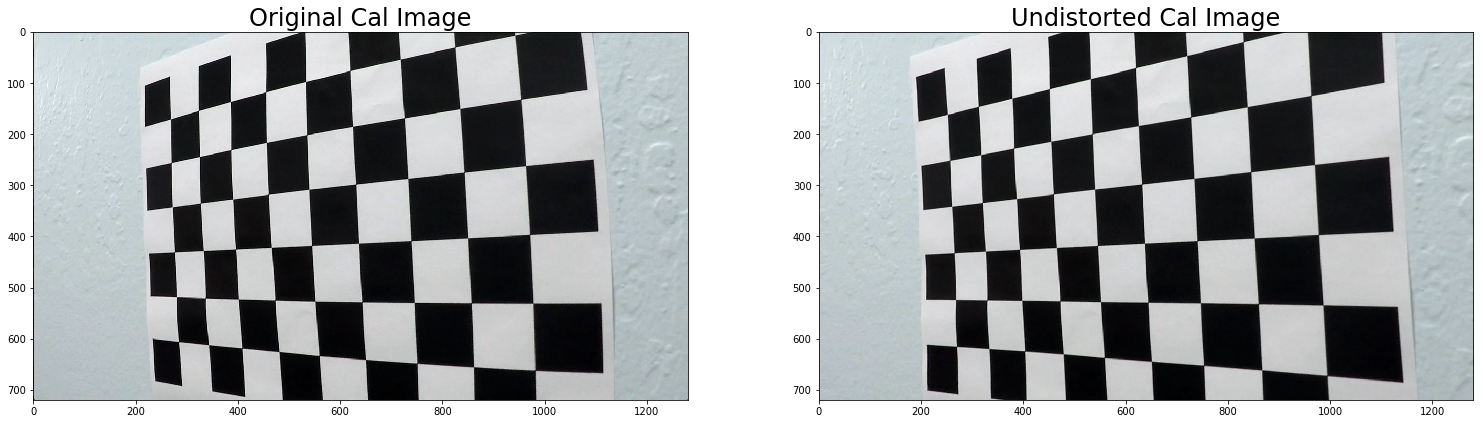

In [4]:
# use chessboard images for calibration
calibration_images = glob.glob('./camera_cal/*.jpg')
objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images)

cal_img=cv2.imread("./camera_cal/calibration4.jpg")
cal_undist = undistort(cal_img,mtx,dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal_img)
ax1.set_title('Original Cal Image', fontsize=24)
ax2.imshow(cal_undist)
ax2.set_title('Undistorted Cal Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/cal_undist.jpg', bbox_inches = 'tight', pad_inches = 0)

### Undistorted test image

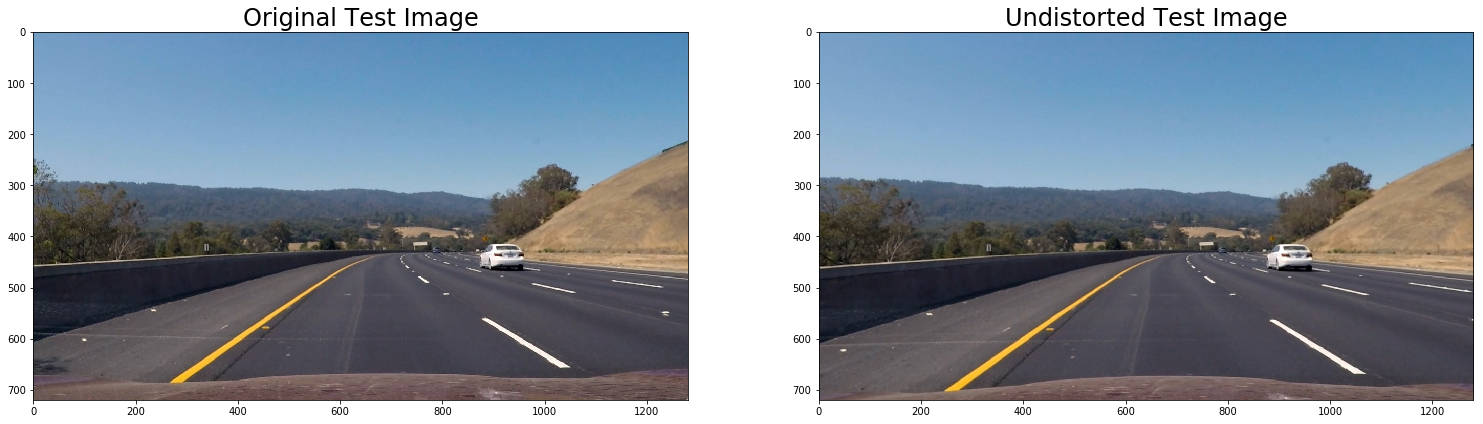

In [5]:
test_img = mpimg.imread('./test_images/test3.jpg')
#test_img = mpimg.imread('./wobbly_lane2.jpeg')
test_undist = undistort(test_img,mtx,dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Test Image', fontsize=24)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Test Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/test_undist.jpg', bbox_inches = 'tight', pad_inches = 0)

### Gradient and Color Thresholding

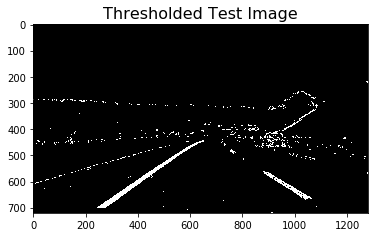

In [6]:
binary_output = color_gradient_thresh(test_undist)
plt.imshow(binary_output/255,cmap='gray')
plt.title('Thresholded Test Image', fontsize=16)
plt.savefig('./output_images/test_binary.jpg', bbox_inches = 'tight', pad_inches = 0)

### Perspective Transform

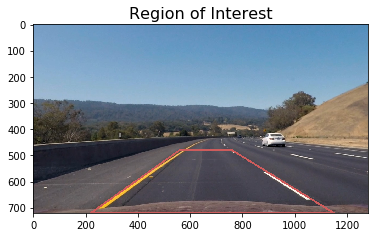

In [7]:
top_left = (560,480)
top_right = (760,480)
bottom_right = (1150,720)
bottom_left = (220,720)
test_undist_roi = test_undist.copy()
cv2.polylines(test_undist_roi,np.array([[top_left,top_right, bottom_right, bottom_left]], dtype=np.int32),True,(205,92,92),5)
plt.imshow(test_undist_roi)
plt.title('Region of Interest', fontsize=16)
plt.savefig('./output_images/test_roi.jpg', bbox_inches = 'tight', pad_inches = 0)


(720, 1280)


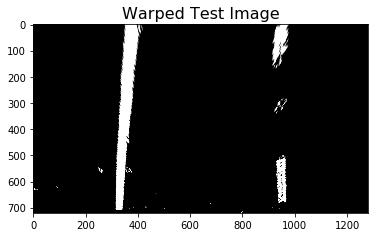

In [8]:
binary_warped,M,Minv = perspective_transform(binary_output)
print(binary_warped.shape)
plt.imshow(binary_warped,cmap='gray')
plt.title('Warped Test Image', fontsize=16)
plt.savefig('./output_images/test_binary_warped.jpg', bbox_inches = 'tight', pad_inches = 0)

### Finding Lane Line Pixels

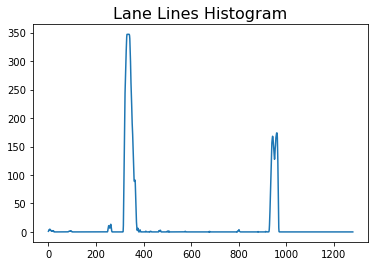

In [9]:
# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)
plt.title('Lane Lines Histogram', fontsize=16)
plt.savefig('./output_images/test_histogram.jpg', bbox_inches = 'tight', pad_inches = 0)

252436.084373
327.378865643 959.223112051


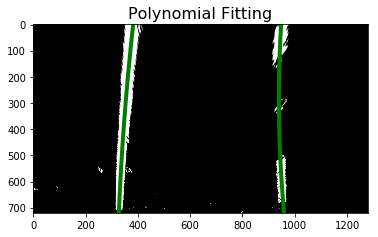

In [10]:
left_fit, right_fit, out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)
#Plotting
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='green',linewidth=4)
plt.plot(right_fitx, ploty, color='green',linewidth=4)
plt.title('Polynomial Fitting', fontsize=16)
plt.savefig('./output_images/test_polynomial.jpg', bbox_inches = 'tight', pad_inches = 0)
print(np.sum(left_fitx))
y = binary_warped.shape[0] 
left_intercept_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
right_intercept_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
print(left_intercept_x,right_intercept_x)

### Radius of Curvature

In [15]:
left_curverad_p,right_curve_rad_p,left_curverad_m, right_curve_rad_m = measure_curvature_pixels_meters(left_fit, right_fit)
print('Pixels: {:04.3f} left, {:04.3f} right'.format(left_curverad_p, right_curve_rad_p))
print('Meters: {:04.3f} left, {:04.3f} right'.format(left_curverad_m,right_curve_rad_m))


Pixels: 10603.240 left, 777.520 right
Meters: 3475.176 left, 158.630 right


### Position of Vehicle

In [19]:
offset,width = lane_offset(binary_warped,left_fit,right_fit)
print(offset,width)

-0.288512019882 3.70231850162


### Project and draw lane measurements back onto road image

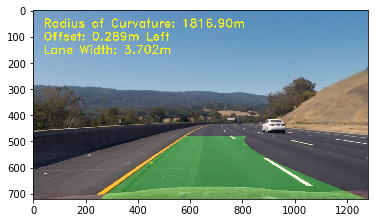

In [20]:
result = draw_fill_lanes(test_undist,binary_warped,left_fit,right_fit,left_curverad_m,right_curve_rad_m,offset,width)
plt.imshow(result)
plt.savefig('./output_images/test_final.jpg', bbox_inches = 'tight', pad_inches = 0)

### Run pipeline on all test images

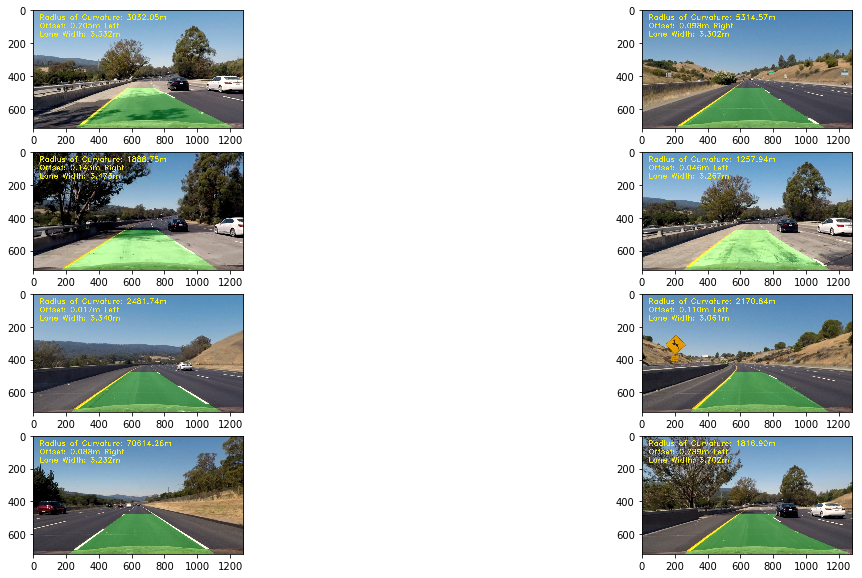

In [23]:
test_images = glob.glob('./test_images/*.jpg')
rows = int(len(test_images)/2)
cols = 2
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(rows, cols, figsize=(20,10))

result = []

# camera calibration matrices mtx and dist were found earlier
for i, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    undist = undistort(img,mtx,dist)
    binary_output = color_gradient_thresh(undist)
    binary_warped,M,Minv = perspective_transform(binary_output)
    left_fit, right_fit, out_img = fit_polynomial(binary_warped)
    left_curverad_p,right_curve_rad_p,left_curverad_m, right_curve_rad_m = measure_curvature_pixels_meters(left_fit, right_fit)
    offset, width = lane_offset(binary_warped,left_fit,right_fit)
    result.append(draw_fill_lanes(undist,binary_warped,left_fit,right_fit,left_curverad_m,right_curve_rad_m,offset,width))
    
# Plot figures
# f.subplots_adjust(wspace=0, hspace=0)
ax1.imshow(result[0])
ax2.imshow(result[1])
ax3.imshow(result[2])
ax4.imshow(result[3])
ax5.imshow(result[4])
ax6.imshow(result[5])
ax7.imshow(result[6])
ax8.imshow(result[7])


## Video Pipeline

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
global count
global left_fit_arr
global right_fit_arr
count = 0
left_fit_arr = np.zeros(shape=[10,3])
right_fit_arr = np.zeros(shape=[10,3])

def process_video(img):
    global count
    global left_fit_avg
    global right_fit_avg
    undist = undistort(img,mtx,dist)
    binary_output = color_gradient_thresh(undist)
    binary_warped,M,Minv = perspective_transform(binary_output)
    if count == 0:
        left_fit, right_fit, out_img = fit_polynomial(binary_warped)
        left_fit_arr[0] = left_fit
        right_fit_arr[0] = right_fit
    else:
        i = count % 10
        left_fit_avg = left_fit_arr[left_fit_arr!=0].reshape(-1,3).mean(axis=0)
        right_fit_avg = right_fit_arr[right_fit_arr!=0].reshape(-1,3).mean(axis=0)
        left_fit, right_fit = search_around_poly(binary_warped,left_fit_avg,right_fit_avg)
        left_fit_arr[i] = left_fit
        right_fit_arr[i] = right_fit
        
    left_curverad_p,right_curve_rad_p,left_curverad_m, right_curve_rad_m = measure_curvature_pixels_meters(left_fit, right_fit)
    offset,width = lane_offset(binary_warped,left_fit,right_fit)
      
    result = draw_fill_lanes(undist,binary_warped,left_fit,right_fit,left_curverad_m,right_curve_rad_m,offset,width)
    count += 1
    return result 

In [28]:
lanes_output = './adv_lanes_project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
lanes_clip = clip1.fl_image(process_video) 
%time lanes_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video ./adv_lanes_project_video.mp4
[MoviePy] Writing video ./adv_lanes_project_video.mp4


100%|█████████▉| 1260/1261 [07:02<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./adv_lanes_project_video.mp4 

CPU times: user 4min 46s, sys: 2.12 s, total: 4min 48s
Wall time: 7min 5s


In [37]:
# clip1.save_frame("wobbly_lane2.jpeg", t=41.8) # save a frame for analysis